In [1]:
import torch
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.nn.functional import relu


In [2]:
if torch.backends.mps.is_available():
    print("MPS is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

print("device: {}".format(device))

MPS is available.
device: mps


(-0.5, 39.5, 39.5, -0.5)

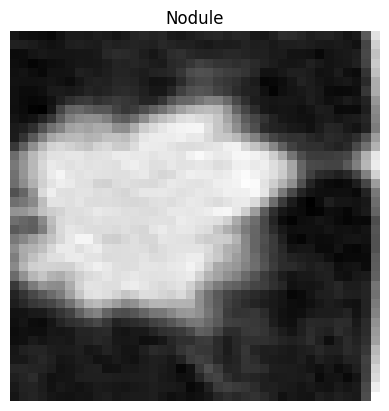

In [3]:
roi_img_list_path = 'data/training_scans/'
roi_img_path = os.listdir(roi_img_list_path)

scans = []
for img in roi_img_path:
    scans.append(sitk.GetArrayFromImage(sitk.ReadImage(roi_img_list_path + img)))

plt.imshow(scans[0][20,:,:], cmap='gray')
plt.title('Nodule')
plt.axis('off')

(-0.5, 39.5, 39.5, -0.5)

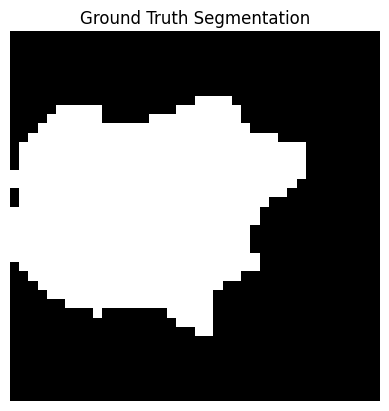

In [4]:
seg_img_list_path = 'data/training_labels'
seg_img_path = os.listdir(seg_img_list_path)

segs = []
for seg in seg_img_path:
    if seg != '.DS_Store':
        segs.append(sitk.GetArrayFromImage(sitk.ReadImage(seg_img_list_path + '/' + seg)))

plt.imshow(segs[0][20,:,:], cmap = 'gray')
plt.title('Ground Truth Segmentation')
plt.axis('off')

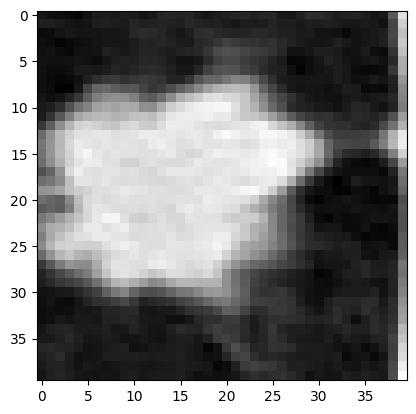

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(scans, dtype='float32'), np.array(segs, dtype='float32'), test_size=2, random_state=42)
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)

plt.imshow(X_train[0][20,:,:], cmap='gray')

MLP Approach

In [6]:
class mlp(torch.nn.Module):
    def __init__(self, input_size, h1_size, h2_size, output_size):
        super(mlp, self).__init__()
        
        device = torch.device('mps')
        self.linear1 = torch.nn.Linear(input_size, h1_size, bias=True, device=device)
        self.linear2 = torch.nn.Linear(h1_size, h2_size, bias=True, device=device)
        self.linear3 = torch.nn.Linear(h2_size, output_size, bias=True, device=device)

        self.activation1 = torch.nn.ReLU()
        self.activation2 = torch.nn.ReLU()
        
    def forward(self, x):
        z1 = self.linear1(x)
        a1 = self.activation1(z1)
        z2 = self.linear2(a1)
        a2 = self.activation2(z2)
        x = self.linear3(a2)
        return x

In [7]:
model = mlp(40,40,40,40)
summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            1,640
├─Linear: 1-2                            1,640
├─Linear: 1-3                            1,640
├─ReLU: 1-4                              --
├─ReLU: 1-5                              --
Total params: 4,920
Trainable params: 4,920
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            1,640
├─Linear: 1-2                            1,640
├─Linear: 1-3                            1,640
├─ReLU: 1-4                              --
├─ReLU: 1-5                              --
Total params: 4,920
Trainable params: 4,920
Non-trainable params: 0

Text(0, 0.5, 'loss')

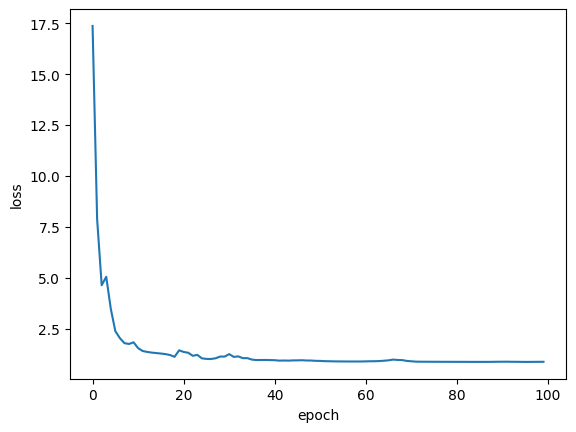

In [8]:
model.to(device)
model.train(True)

inputs = X_train.to(device)
labels = Y_train.to(device)

lr = 0.01 # learning rate/step size for gradient descent
epochs = 100

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Create empty list to store loss value each epoch
nn_history = []

for epoch in range(epochs):

    # Set all gradients to zero each epoch
    optimizer.zero_grad()

    # Forward pass to compute logits
    outputs = model(inputs)

    # Compute the loss 
    loss = loss_fn(outputs, labels)

    # Backward pass to compute gradients
    loss.backward()

    # Update weights
    optimizer.step()
    
    # For visualization
    nn_history.append(loss.item())
    
# Plot loss per epoch
fig, ax = plt.subplots()
ax.plot(nn_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")


In [9]:
def accuracy(y_pred, y_true):
    preds = torch.argmax(y_pred, dim=1)
    acc = (preds == y_true).float().mean()
    return acc

# TODO: get predictons on test dataset and print accuracy
X_test_tensor = torch.from_numpy(X_test).to('mps')
Y_test_tensor = torch.from_numpy(Y_test).to('mps')
print(f'accuracy: {accuracy(model(X_test_tensor[0]), Y_test_tensor[0])}')

accuracy: 0.007500000298023224


(-0.5, 39.5, 39.5, -0.5)

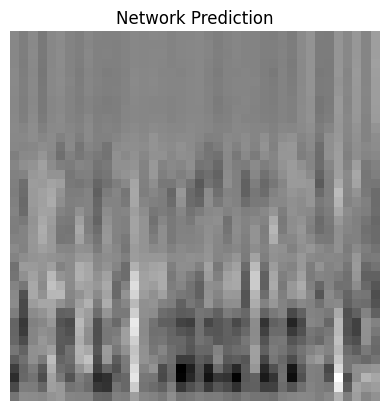

In [10]:
test_segmentation = model(X_test_tensor)
test_segmentation = test_segmentation.cpu()
test_segmentation_np = test_segmentation.detach().numpy()

plt.imshow(test_segmentation_np[0][15,:,:], cmap='gray')
plt.title('Network Prediction')
plt.axis('off')

Obviously not the best... Training size is tiny but we can definitely change some stuff first

CNN Approach - U-Net

From tutorial https://www.youtube.com/watch?v=HS3Q_90hnDg

In [6]:
import torch.nn as nn

class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            # first 2 convolutions, ReLU (clamp) function to keep nonlinearity
            # keep same sizse
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True)
        )

    # forward pass
    def forward(self, x):
        return self.conv_op(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConvolution(in_channels, out_channels) # perform double convolution
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # max pooling to downsample feature data
    
    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConvolution(in_channels, out_channels)
                                      
    def forward(self, x1, x2):
        x1 = self.up(x1)
        print(x1.size(), x2.size())
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

U-Net

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        # down convolutions
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        # double convolution bottleneck
        self.bottle_neck = DoubleConvolution(512, 1024)

        # up convolutinos
        
        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        # final convolution kernel size 1
        self.out = torch.nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)


        b = self.bottle_neck(p4)

        print(f'upsamples: {p1.shape, p2.shape, p3.shape, p4.shape, b.shape}')

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        return self.out(up_4)

        

Apply

DoubleConvolution(
  (conv_op): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
)
upsamples: (torch.Size([1, 64, 256, 256]), torch.Size([1, 128, 128, 128]), torch.Size([1, 256, 64, 64]), torch.Size([1, 512, 32, 32]), torch.Size([1, 1024, 32, 32]))
torch.Size([1, 512, 64, 64]) torch.Size([1, 512, 64, 64])
torch.Size([1, 256, 128, 128]) torch.Size([1, 256, 128, 128])
torch.Size([1, 128, 256, 256]) torch.Size([1, 128, 256, 256])
torch.Size([1, 64, 512, 512]) torch.Size([1, 64, 512, 512])
torch.Size([1, 4, 512, 512])


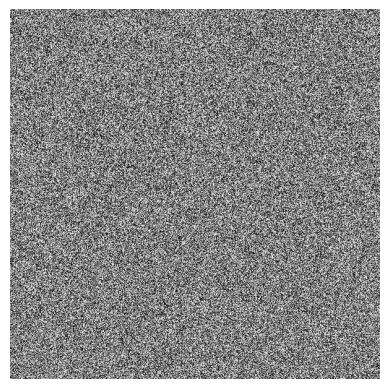

In [8]:
double_conv = DoubleConvolution(256,256)
print(double_conv)

input_img = torch.rand((1,3,512,512))
plt.imshow(input_img[0,2,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
    
model = UNet(3,4)
output = model(input_img)
print(output.size())

(-0.5, 511.5, 511.5, -0.5)

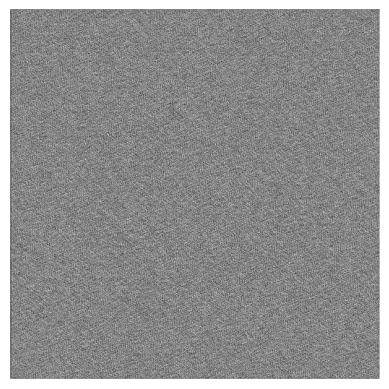

In [9]:
output_np = output.detach().numpy()
plt.imshow(output_np[0,2,:,:], cmap='gray')
plt.axis('off')

Training and testing U-Net on our tiny tester dataset

In [10]:
import torch.optim as optim

lr = 3e-4
epochs = range(100)

X_train, X_test, Y_train, Y_test = train_test_split(np.array(scans, dtype='float32'), np.array(segs, dtype='float32'), test_size=2, random_state=42)
X_train = torch.from_numpy(X_train).float().to('mps')
Y_train = torch.from_numpy(Y_train).float().to('mps')

print(X_train.size())

model = UNet(in_channels=40, num_classes =1).to('mps')
optimizer = optim.AdamW(model.parameters(), lr=lr)


for epoch in epochs:
    model.train()
    loss_running = 0

    for idx,img in enumerate(X_train):
        y_pred = model(img)
        optimizer.zero_grad()
        loss = criterion(y_pred,Y_train[idx])
        loss_running += loss.item()
                         
        loss.backward()
        optimizer.step

    train_loss = loss_running / idx + 1
    model.eval
    val_running_loss = 0

    with torch.no_grad():
        for idx, img in enumerate(X_test):
            y_pred = model(img)
            loss = criterion(y_ored, Y_test[idx])

            val_running_loss += loss.item()

        val_loss = val_running_loss / idx + 1

    print('-'*30)
    print(f'train loss epoch {epoch+1}: {train_loss:.4f}')
    print(f'val loss epoch {epoch+1}: {val_loss:.4f}')
    print('-'*30)


torch.Size([6, 40, 40, 40])
upsamples: (torch.Size([64, 20, 20]), torch.Size([128, 10, 10]), torch.Size([256, 5, 5]), torch.Size([512, 2, 2]), torch.Size([1024, 2, 2]))
torch.Size([512, 4, 4]) torch.Size([512, 5, 5])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 4 but got size 5 for tensor number 1 in the list.